# Planetary Orbit

_Colin Leach, June 2018_

## Contents

- [Introduction](#Intro)
- [Keplerian Ellipse](#Kepler)
- [Newtonian Gravity](#Newton)
- [Interactive plot](#Interactive)
- [Animated plots](#Animated)

<a id='Intro'></a>    
## Introduction

A simple time-stepping simulation of a planet orbiting a massive star, or equivalently the orbit of the reduced mass about the system's center of mass.

There are multiple ways to model the orbit. One is to constrain it to a perfect ellipse and follow Kepler's laws, with constant angular momentum. Here the key result is to determine $d\theta$ at each time step, the angle swept out by the orbit.

Another approach is to start the planet with an appropriate momentum, for example at perihelion, then let the orbit evolve under Newtonian gravity. If all goes well, it will trace out an ellipse despite this being a $t=0$ boundary condition rather than an explicit constraint.

<a id='Kepler'></a>  
## Keplerian ellipse

From Kepler's first law, the distance from the principal focus is
$$r = \frac{a(1-e^2)}{1+e \cos \theta} \qquad (0 \le e < 1)$$

The angular momentum per unit mass is
$$ \frac{L}{m} = \sqrt{G M a (1-e^2)} $$
Note that this is a maximum for purely circular motion ($e = 0$) and goes to zero as the eccentricity approaches unity.

From Kepler's second law, the time rate if change of area is
$$ \frac{dA}{dt} = \frac{1}{2} r^2 \frac{d \theta}{dt} = \frac{1}{2} \frac{L}{m} \quad \Rightarrow \quad d \theta = \frac{L}{m r^2} dt $$
So we could use this $d \theta$ for our time steps. 

In the nature of numerical simulations, this relies on keeping $dt$, and hence $d \theta$, small enough (whatever "enough" turns out to be). This gives us more points than can be fitted comportably on a graphical plot, so eventually we will take every $n^{th}$ point for plotting.

<a id='Newton'></a>  

## Newtonian gravity

The velocity at any point on an elliptical orbit is
$$ v = \sqrt{G M \left( \frac{2}{r} - \frac{1}{a} \right) } $$
At perihelion we know that $r = a(1-e)$, so
$$ \vec{v}_{ph} = \sqrt{G M \left(\frac{2}{a(1-e)} - \frac{1}{a}\right)}\, \hat{v} \quad=\quad \sqrt{\frac{G M}{a} \frac{1+e}{1-e}}\, \hat{v} $$
Also, at perihelion (and aphelion) this velocity is a vector perpendicular to the star-planet vector $\vec{r}$.

At each time step the planet experiences a gravitational acceleration towards the star (in the $-\hat{r}$ direction):
$$ \vec{a} =  \dot{\vec{v}} = -\frac{G M}{r^2} \hat{r} \qquad \Rightarrow \qquad d\vec{v} =  \dot{\vec{v}}\, dt = -\frac{G M}{r^2} \hat{r}\,dt \qquad \Rightarrow \qquad d\vec{r} = \vec{v}\,dt $$
Thus we have a way to update $\vec{r}$ and $\vec{v}$ at each time step.

As a way of doing numerical integration of a differential equation, $\vec{r} = \int \vec{v}(t)\, dt$, this first-order (Euler) method is at the crude end of the range of possibilities. It does tolerably well for a single orbit but is slow and is likely to become unstable over longer times. 

A better alternative would be a 4th-order Runge-Kutta method. Rather than implement this from scratch, the `scipy.integrate` package offers a variety of optimized and tested options. The code below uses `solve_ivp()` which is designed for initial value problems like this. The function is a wrapper for a variety of ODE solvers but defaults to rk45.

In [1]:
# inline vs notebook: see discussion at the bottom of this notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.constants import G
from astropy.table import QTable

from scipy.integrate import solve_ivp

from IPython.display import Image, HTML
from matplotlib import animation
from matplotlib.offsetbox import AnchoredText

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as w

Define some utility functions:

In [2]:
def veclen(vector):
    # beware, units are lost and this just returns a number
    return np.linalg.norm(vector) 

def vecperp(vector):
    "rotate 90 deg ccw, return normalised vector in x,y plane"
    v = np.array([-vector[1], vector[0], 0])
    return v/veclen(v)

def makeResultsTable(sol):
    # put the results in an astropy table, with units
    results = QTable()
    results['t'] = (sol.t*u.s).to(u.year)
    results['x'] = (sol.y[0,:]*u.m).to(u.AU)
    results['y'] = (sol.y[1,:]*u.m).to(u.AU)
    results['z'] = (sol.y[2,:]*u.m).to(u.AU)
    results['vx'] = sol.y[3,:]/1000*u.km/u.s
    results['vy'] = sol.y[4,:]/1000*u.km/u.s
    results['vz'] = sol.y[5,:]/1000*u.km/u.s
    return results    

Define the calculation so it can be called from the various types of plot. A limitation of using a standard integrator is incompatibility with astropy units, so we convert everything to SI and use unit-free values.

In [3]:
def calcOrbit(Mstar, a, e, i=0, phi=0, nOrbits=1, dt=None, points_per_orbit=200):
    """Parameters: Mstar = central mass, with units
                   a = semimajor axis, with units
                   e = eccentricity
                   i = inclination (deg)
                   phi = orientation of perihelion (deg ccw from x-axis)
                   nOrbits = number of full periods
                   dt = time step (s)
                   points_per_orbit: used to calculate dt if necessary """

    # get everything into SI and strip off the units
    G_val = 6.67408e-11 # SI units
    Mstar = Mstar.to(u.kg).value
    a = a.to(u.m).value
    i = i*np.pi/180 # to radians
    phi = phi*np.pi/180
    
    # calculate expected orbital period and time step
    P = np.sqrt(4 * np.pi**2 * a**3/(G_val * Mstar))
    if dt is not None:
        dt = dt.to(u.s).value
    else:
        dt = P/points_per_orbit # seconds

    # set the total time range, and the intermediate time points
    t_span = (0, P*nOrbits) # (start, end) 2-tuple
    t_vals = np.arange(0, P*nOrbits, dt) # 1-D array of time points

    # set starting position and velocity, at perihelion
    r_dir = np.array([np.cos(phi), np.sin(phi), np.sin(i)]) 
    rhat = r_dir/veclen(r_dir)
    r_vec = a*(1-e) * rhat
    
    vhat = vecperp(rhat) 
    v_vec = np.sqrt(G_val*Mstar/a*(1+e)/(1-e)) * vhat
    
    # the solver needs a 6-vector: [x,y,z,x',y',z']
    initial_value = np.r_[r_vec, v_vec]

    # define a callable for the solver; returns dy/dt 6-vector
    def kepler(t, y):
        r_in = y[:3]
        v_in = y[3:]
        r = veclen(r_in)
        a = G*Mstar/r**3 * -r_in # scalar * reciprocal position vector
        return np.r_[v_in, a]
    
    # let scipy.integrate do the heavy work
    sol = solve_ivp(kepler, t_span, initial_value, t_eval=t_vals, max_step=dt)
    if not sol.success:
        display(sol.message)
    
    return makeResultsTable(sol)

How good is the simulation? One way to test it is to calculate several orbits and see if they coincide or drift apart with time. 

The code for this is in the cells below. A bit of testing suggests that the results look pretty tight with a 1-day step size but degrade substantially with longer steps (the ellipticity gradually decreases). Letting the solver choose its own values produces terrible results, with only a few points per orbit.

In [4]:
# nOrbits = 5
nOrbits = 100

Mstar = 1*u.M_sun
a = 1*u.AU
e = 0.8 # highly elliptical orbits probably have worse errors

data = calcOrbit(Mstar, a, e, dt=1*u.day)

A simple plot of the multiple orbits:

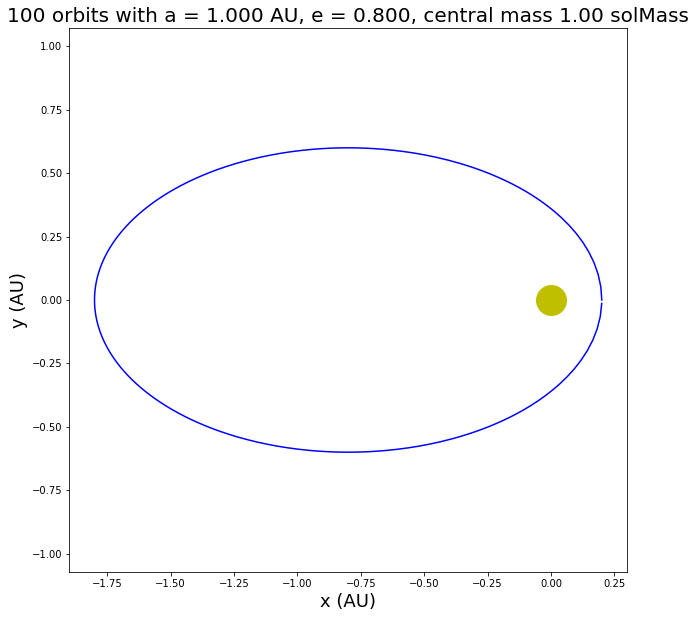

In [5]:
figwidth = 10
fig = plt.figure(figsize=(figwidth, figwidth))
#     fig, ax = plt.subplots(figsize=(figwidth, figwidth))
plt.plot(data['x'], data['y'], 'b-')
plt.axis('equal')
plt.plot(0,0,'yo',markersize=30)
plt.xlabel('x (AU)', fontsize=18)
plt.ylabel('y (AU)', fontsize=18)
plt.title('{3} orbits with a = {0:.3f}, e = {1:.3f}, central mass {2:.2f}'
          .format(a.to(u.AU), e, Mstar.to(u.Msun), nOrbits), fontsize=20);

***

<a id='Interactive'></a>  
## Interactive Plot

Jupyter/Python notebooks support many types of interactivity via `ipywidgets`. These link to a function, in this case `plotOrbit()`, to update the display however the programmer chooses.

First define the plot, within a function so it can be called interactively:

In [12]:
def plotOrbit(Mstar, a, ecc, dt):
    
    Mstar *= u.Msun
    a *= u.AU
    dt *= u.day
    
    # run the calculation
    orbitData = calcOrbit(Mstar, a, ecc, dt=dt)
    
    # set some useful values for plotting and annotation
#     stepcount = 5 # plot every 5th time step
#     steptime = (orbitData['P']/orbitData['n']*stepcount).to(u.day)
    P = np.sqrt(4 * np.pi**2 * a**3/(G * Mstar))
    perihelion = a*(1-ecc)
    aphelion = a*(1+ecc)
    
    # make the plot
    plt.ioff
#     figwidth = 10
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.axis('equal')
    plt.plot(0,0,'yo',markersize=30)
    plt.plot(orbitData['x'], orbitData['y'], 'b*')
    plt.xlabel('x (AU)', fontsize=18)
    plt.ylabel('y (AU)', fontsize=18)
    plt.title('Orbit with a = {0:.3f}, e = {1:.3f}, central mass {2:.2f}'
              .format(a.to(u.AU), ecc, Mstar.to(u.Msun)), fontsize=20);
    at = AnchoredText("Period {0:.4f}\nStep time {1:.3f}\nPerihelion {2:.3f}\nAphelion {3:.3f}"
                        .format(P.to(u.year), dt, perihelion, aphelion),
                      prop=dict(size=12), frameon=True,
                      loc=2,
                      )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

Set up the slider controls for interaction with the plot. Continuous update probably needs to be turned off, so the plot will redraw once you release the slider (mouse button up). To avoid long delays it is best to increase the time step __before__ increasing the semimajor axis.

In [13]:
style = {'description_width': 'initial'} # to avoid the labels getting truncated
interact(plotOrbit, 
             Mstar = w.FloatSlider(description="Central Mass (M_sun)", style=style,
                                            layout=Layout(width='80%'),
                                            continuous_update=False, # otherwise flicker is horrible
                                            min=0.3, max=20, 
                                            value=1.0), 
             a = w.FloatSlider(description="Semimajor axis (AU)", style=style,
                                            layout=Layout(width='80%'),
                                            continuous_update=False,
                                            min=0.1, max=30, 
                                            value=1.0),
             ecc = w.FloatSlider(description="Eccentricity", style=style,
                                            layout=Layout(width='80%'),
                                            continuous_update=False, 
                                            min=0.0, max=0.99, step=0.01,
                                            value=0.1),
             dt = w.FloatSlider(description="Time step (day)", style=style,
                                            layout=Layout(width='80%'),
                                            continuous_update=False,
                                            min=0.1, max=100, 
                                            value=1.0));


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Central Mass (M_sun)', layo…

***

<a id='Animated'></a>  
## Animated Plots

Making the planet move around the plot requires a different approach. Matplotlib has included animation support since about v2.1. This is great, but it doesn't combine well with the interactivity shown in the previous section: the setup is somewhat different, and pre-rendering the movie before it displays is too slow for rapid interaction.

Therefore, everything below is disconnected from the orbit parameter sliders. Edit the Python code in the next cell to set the values to model.

First calculate some data:

In [8]:
#*******************************************************
#
#  This is where to set values for the orbit animation
#
#*******************************************************
Mstar = 1    # M_sol
a = 1        # AU
ecc = 0.6    # more visual than a circular orbit !

Next generate orbit data:

In [17]:
# convert the parameters into the right units
Mstar_kg = (Mstar * u.M_sun).to(u.kg)
a_m = (a * u.AU).to(u.m)

# run the calculation, returning a QTable of data
orbit_data = calcOrbit(Mstar_kg, a_m, ecc)

# add some extra columns for radius, total velocity and angle
orbit_data['r'] = np.sqrt(orbit_data['x']**2 
                              + orbit_data['y']**2 
                              + orbit_data['z']**2)
orbit_data['v_tot'] = np.sqrt(orbit_data['vx']**2 
                              + orbit_data['vy']**2 
                              + orbit_data['vz']**2)
orbit_data['theta_rads'] = np.arctan2(orbit_data['y'], orbit_data['x'])   
# angles -180 < theta < 180 will mess up our later plot, 
# so convert to 0 < theta < 360
orbit_data['theta_rads'][orbit_data['theta_rads'] < 0 ] += 2*np.pi*u.rad 

orbit_data[:5]

<QTable length=5>
         t                    x          ...      theta_rads    
         yr                   AU         ...         rad        
      float64              float64       ...       float64      
-------------------- ------------------- ... -------------------
                 0.0 0.39999999999999997 ...                 0.0
0.005000094433730895  0.3969267818449244 ... 0.15659818900740438
 0.01000018886746179 0.38783655468795886 ...  0.3103785756360451
0.015000283301192685  0.3730965272797799 ... 0.45885452318258846
 0.02000037773492358 0.35325584350552425 ...  0.6001082589352081

*Set up some animation parameters and a skeleton plot which **should not*** yet display. If it does, that's a bug - see discussion of Issues at the end of this notebook.

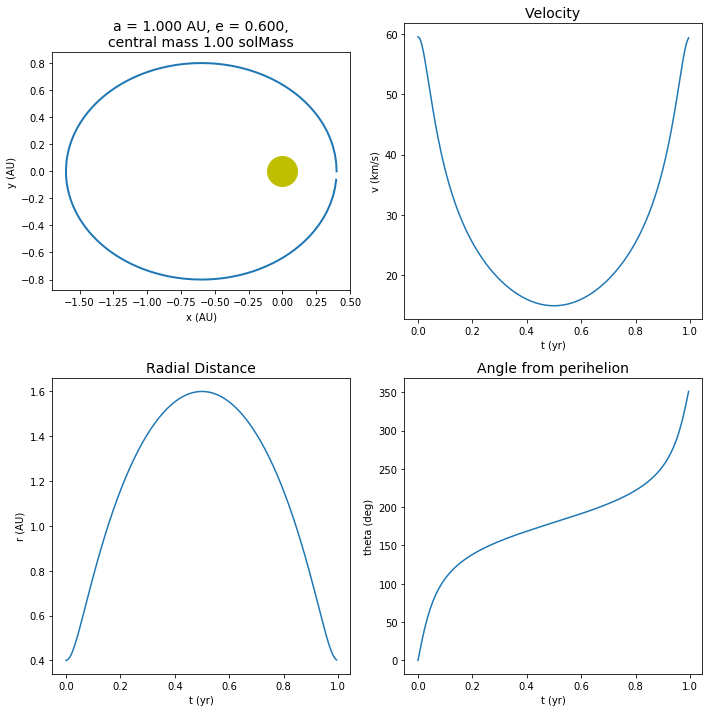

In [36]:
Nframes = 50
# get subset of x,y arrays for Nframes planet positions for animation
data_ratio = orbit_data['x'].size // Nframes
x_planet = orbit_data['x'][::data_ratio]
y_planet = orbit_data['y'][::data_ratio]

t_full = orbit_data['t']
v_full = orbit_data['v_tot']
r_full = orbit_data['r']
theta_full = orbit_data['theta_rads'].to(u.deg)
t_planet = t_full[::data_ratio]
v_planet = v_full[::data_ratio]
r_planet = r_full[::data_ratio]
theta_planet = theta_full[::data_ratio]

# Now set up the figure, the axis, and the plot element we want to animate
plt.ioff()
figwidth = 10
fig_anim = plt.figure(figsize=(figwidth, figwidth))

# add the main orbit plot
axo = plt.subplot2grid((2,2), (0,0), aspect='equal')

axo.plot(0,0,'yo',markersize=30) # the star
axo.plot(orbit_data['x'], orbit_data['y'], lw=2)
axo.set_xlabel('x (AU)')
axo.set_ylabel('y (AU)')
axo.set_title('a = {0:.3f}, e = {1:.3f},\ncentral mass {2:.2f}'
          .format(a_m.to(u.AU), ecc, Mstar_kg.to(u.Msun)), fontsize=14)
planet, = axo.plot([], [], 'go', ms=15)

axv = plt.subplot2grid((2,2), (0,1))
axv.plot(t_full, v_full)
axv.set_xlabel('t (yr)') 
axv.set_ylabel('v (km/s)') 
axv.set_title('Velocity', fontsize=14)             
planetv, = axv.plot([], [], 'go', ms=10);

# add the r-t plot
axr = plt.subplot2grid((2,2), (1,0))
axr.plot(t_full, r_full)
axr.set_xlabel('t (yr)') 
axr.set_ylabel('r (AU)') 
axr.set_title('Radial Distance', fontsize=14)             
planetr, = axr.plot([], [], 'go', ms=10);


# add the theta-t plot
axth = plt.subplot2grid((2,2), (1,1))
axth.plot(t_full, theta_full)
axth.set_xlabel('t (yr)') #, fontsize=18)
axth.set_ylabel('theta (deg)') #, fontsize=18)
axth.set_title('Angle from perihelion', fontsize=14)             
planetth, = axth.plot([], [], 'go', ms=10);

plt.tight_layout()  # to stop the plots overlapping

Define the two functions needed by the animation. `init()` sets blank data for the planet,` animate(i)` sets data for step i. 

Passing parameters is messy, so for simplicity make sure all the variables you need to access are in the top-level scope.

In [37]:
def init():
    planet.set_data([], [])
    planetv.set_data([], [])
    planetr.set_data([], [])
    planetth.set_data([], [])
    return (planet, planetv, planetr, planetth)

def animate(i):
    # called for each frame
    # this is a really bad place to put anything compute-intensive
    x = x_planet[i]
    y = y_planet[i]
    planet.set_data(x, y)
    
    xv = t_planet[i]
    yv = v_planet[i]
    planetv.set_data(xv, yv)
    
    xr = t_planet[i]
    yr = r_planet[i]
    planetr.set_data(xr, yr)
    
    xth = t_planet[i]
    yth = theta_planet[i]
    planetth.set_data(xth, yth)
    
    return (planet, planetv, planetr, planetth)

Define the animation object. It doesn't do much until you pass it to a renderer.

In [38]:
anim = animation.FuncAnimation(fig_anim, animate, init_func=init,
                               frames=Nframes, interval=50, blit=True)

Now do the slow bit, rendering all the frames in a format the browser can display. Here we use `to_jshtml()`; another option is `to_html5_video()` to get h264 video. 

The `display_animation()` syntax is something that turns up in Google searches but it is probably now obsolete (since this functionality was incorporated in Matplotlib). It seems to do pretty much the same as `to_jshtml()`, but requires a non-standard package to be installed.

Click the play button and away you go. The + and - buttons are for speed control. The Reflect option is what astronomers might call "unphysical", but it's not obvious how to hide it.

In [39]:
%time HTML(anim.to_jshtml())

CPU times: user 8.56 s, sys: 156 ms, total: 8.71 s
Wall time: 8.71 s


***

<a id='Issues'></a>  
## Issues

In separate notebooks, the interactive plot worked best with
`%matplotlib inline`
and the animated plot with
`%matplotlib notebook`

Since combining them in one notebook, there is some conflict. The interactive plot really needs `%matplotlib inline`, but then the animation setup (sometimes? always?) creates an unwanted static plot immediately, in addition to the movie created by a later cell. From discussions on Stackoverflow it's clear others have had related problems, but the fix is currently elusive.

Generating the movie is quite slow (i7 processor, single-threaded). Could parallel processing help in some way?